In [1]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       # Data Formatting


In [2]:
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
opth='/Users/gett613/Data/hackathon/'

CPU times: user 1.94 s, sys: 2.68 s, total: 4.62 s
Wall time: 20.6 s


Text(0.5, 1.0, 'SCREAM OLR 2020-01-05')

<Figure size 1200x800 with 0 Axes>

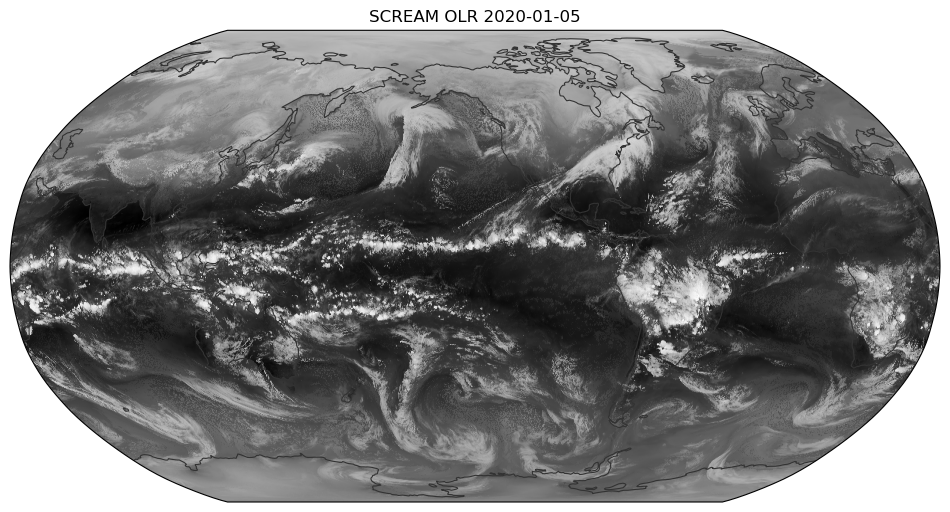

In [4]:
%%time
#s='6'; dkm='100'
#s='8'; dkm='25'
s='10' ; dkm='6'

res=' ('+dkm+'km)'

ofn=opth+"test_dask_remap_1mo_to_hp"+s+"_V3.zarr"

ds=xr.open_dataset(ofn)

#ds['crs'].attrs['healpix_nside'] = 2**int(s)  #This corrects a mistake in Andrew's v1 and v2 zarr files.

# Add coordinates (lat and lon)
ds=ds.pipe(egh.attach_coords)

tm='2020-01-05'
egh.healpix_show(ds.LW_flux_up_at_model_top.sel(time=tm)[0],cmap='binary')
plt.title('SCREAM OLR '+tm) #+' HEALPix Level '+s+res)

### Regional Plot

CPU times: user 64.5 ms, sys: 16.6 ms, total: 81.1 ms
Wall time: 150 ms


/Users/gett613/opt/miniconda3/envs/hackathon0/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Text(0.5, 1.0, 'SCREAM OLR 2020-01-05 HEALPix Level 0 (6km)')

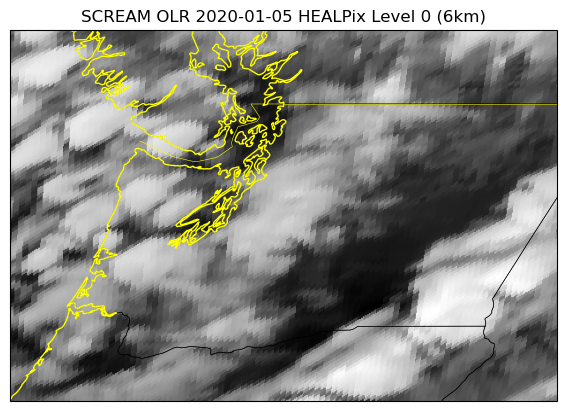

In [19]:
%%time
projection = ccrs.Robinson(central_longitude=10)
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
#Europe
#ax.set_extent([-10, 30, 30, 60], crs=ccrs.PlateCarree())

#W. US
#ax.set_extent([-130, -110, 30, 50], crs=ccrs.PlateCarree())

#N. CA
#ax.set_extent([-124, -122, 37, 40], crs=ccrs.PlateCarree())

#Pac NW
ax.set_extent([-124, -119, 45, 50], crs=ccrs.PlateCarree())

tm2='2020-01-05'

egh.healpix_show(ds.LW_flux_up_at_model_top.sel(time=tm2)[0],ax=ax,cmap='binary')
ax.add_feature(cf.STATES, linewidth=0.4)
ax.add_feature(cf.BORDERS, linewidth=0.4,color='yellow')
ax.add_feature(cf.COASTLINE, linewidth=1.,color='yellow')
plt.title('SCREAM OLR '+tm2+' HEALPix Level '+s+res)

### Timeseries Plot

/Users/gett613/opt/miniconda3/envs/hackathon0/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/Users/gett613/opt/miniconda3/envs/hackathon0/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)


CPU times: user 4.03 s, sys: 8.82 s, total: 12.9 s
Wall time: 49.7 s


Text(0, 0.5, 'Global mean OLR (Wm$^{-2}$)')

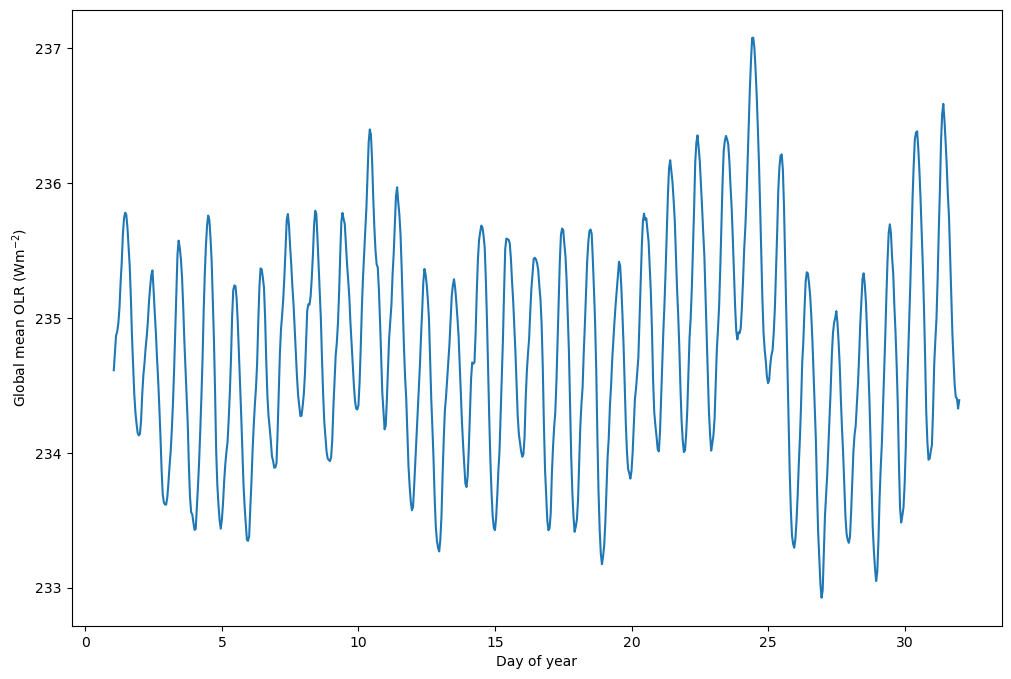

In [10]:
%%time
s='8'
ofn=opth+"test_dask_remap_1mo_to_hp"+s+"_V3.zarr"
ds1=xr.open_dataset(ofn)
ds1=ds1.pipe(egh.attach_coords)

ts=ds1.LW_flux_up_at_model_top.mean("cell")
days=ds1.time.dt.dayofyear+ds1.time.dt.hour/24.
plt.plot(days,ts)
plt.xlabel('Day of year')
plt.ylabel(r'Global mean OLR (Wm$^{-2}$)')

### Timeseries again with lower resolution data

CPU times: user 49 ms, sys: 27.1 ms, total: 76.1 ms
Wall time: 195 ms


/Users/gett613/opt/miniconda3/envs/hackathon0/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/Users/gett613/opt/miniconda3/envs/hackathon0/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)


Text(0, 0.5, 'Global mean OLR (Wm$^{-2}$)')

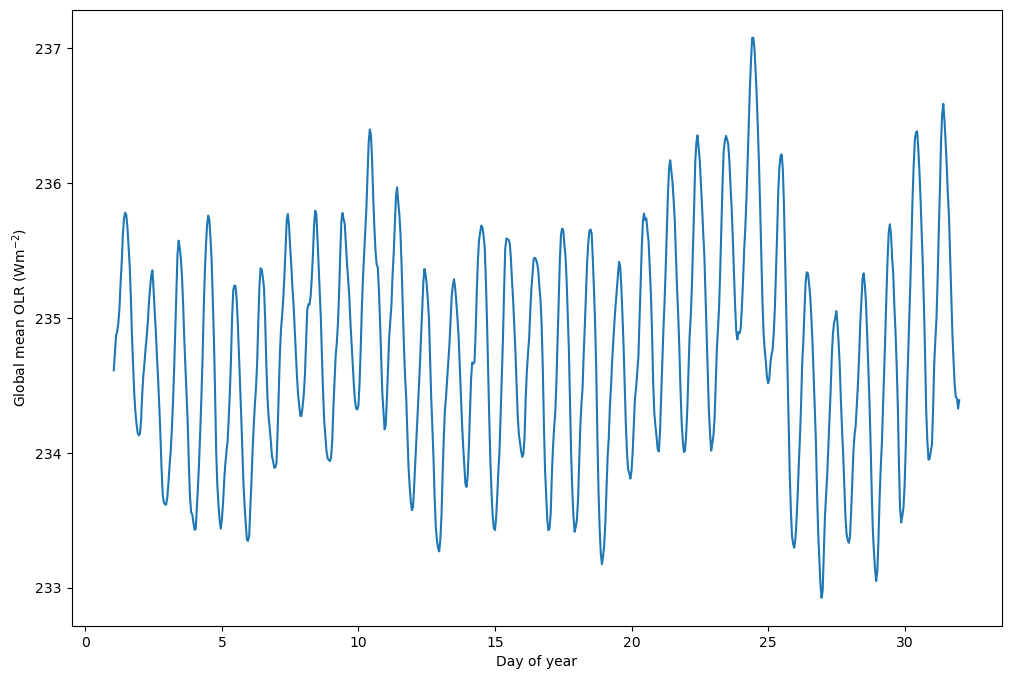

In [17]:
%%time
s='0'
ofn=opth+"test_dask_remap_1mo_to_hp"+s+"_V3.zarr"

ds0=xr.open_dataset(ofn)
ts=ds0.LW_flux_up_at_model_top.mean("cell")
days0=ds0.time.dt.dayofyear+ds0.time.dt.hour/24.
plt.plot(days0,ts)
plt.xlabel('Day of year')
plt.ylabel(r'Global mean OLR (Wm$^{-2}$)')

### Zonal Mean

In [13]:
%%time

var = "LW_flux_up_at_model_top"
zm = (
    ds1[var]
    .groupby("lat")
    .mean()
).compute()

CPU times: user 5.74 s, sys: 7.2 s, total: 12.9 s
Wall time: 20.6 s


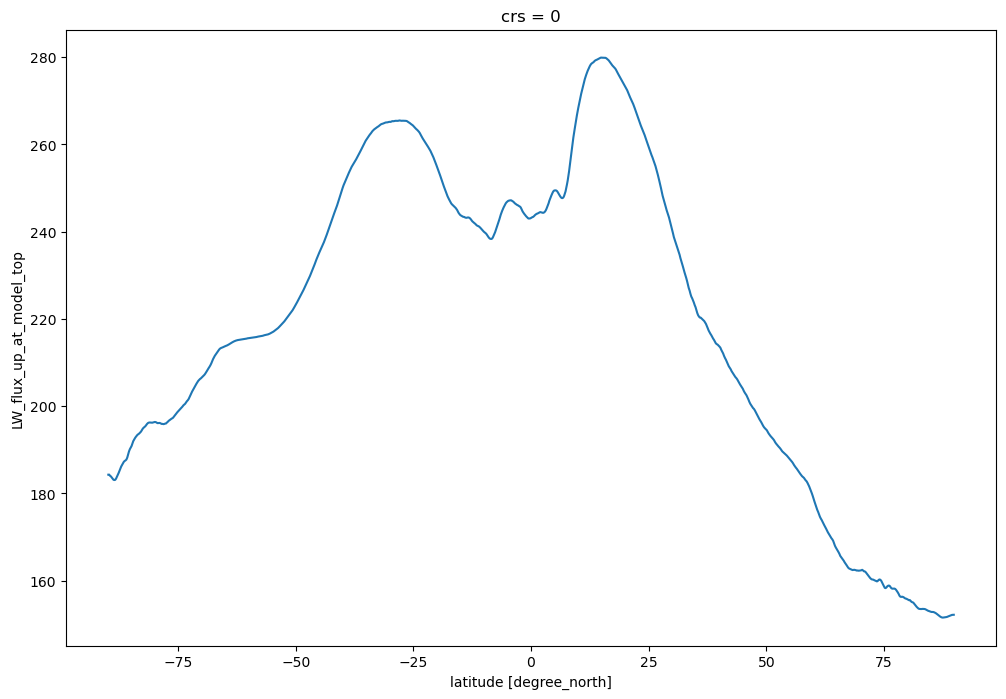

In [36]:
zm.mean(dim='time').plot()

### Define some domains

In [14]:
domains = {
    "atlantic": lambda ds: ds["lon"] > 300,
    "east pacific": lambda ds: (ds["lon"] > 210) & (ds["lon"] < 270.0),
    "maritime continent": lambda ds: (ds["lon"] > 110) & (ds["lon"] < 150.0),
    "indian ocean": lambda ds: (ds["lon"] > 60) & (ds["lon"] < 120.0),
    "global": lambda ds: True,
}


def cells_of_domain(ds, domain_name):
    return np.where(domains[domain_name](ds))[0]

### Regional zonal mean

In [38]:
%%time
var = "LW_flux_up_at_model_top"
domain = "atlantic"
da = (
    ds1[var]
    .isel(cell=cells_of_domain(ds, domain))
#    .resample(time="1H")
#    .mean(dim="time")
    .groupby("lat")
    .mean()
).compute()

CPU times: user 1.08 s, sys: 269 ms, total: 1.35 s
Wall time: 1.35 s


In [40]:
#%%time
#plt.contourf(da.lat,days,da)

### Hovemoller

In [16]:
%%time

var_lon = "LW_flux_up_at_model_top"

Slim, Nlim = 15.0, 35.0
t1, t2 = "2020-01-01", "2020-02-01"
da_by_lon = (
    ds1[var_lon]
    .sel(time=slice(t1, t2))
    .where((ds1["lat"] > Slim) & (ds1["lat"] < Nlim),drop=True)
    .groupby("lon")
    .mean()
).compute()

CPU times: user 1.66 s, sys: 586 ms, total: 2.25 s
Wall time: 2.25 s


<unknown>:4: SyntaxWarning: invalid escape sequence '\c'
<unknown>:4: SyntaxWarning: invalid escape sequence '\c'


CPU times: user 198 ms, sys: 38.8 ms, total: 237 ms
Wall time: 375 ms


Text(0.5, 1.0, 'LW_flux_up_at_model_top: 15.0$^{\\circ}$ to 35.0$^{\\circ}$')

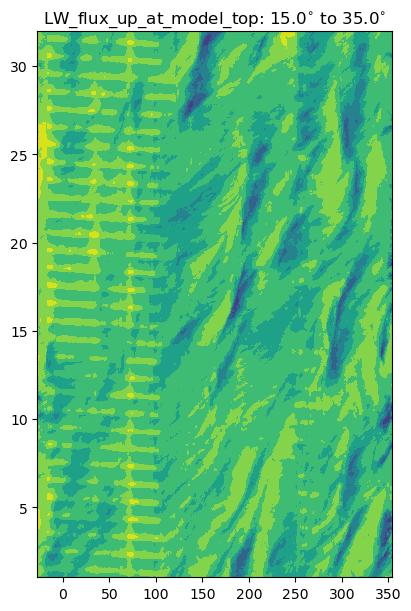

In [17]:
%%time
days=ds1.time.dt.dayofyear+ds1.time.dt.hour/24.
fig, ax = plt.subplots(figsize=(4, 6), constrained_layout=True)
plt.contourf(da_by_lon.lon,days,da_by_lon)
ax.set_title(f"{var_lon}: {Slim}$^{{\circ}}$ to {Nlim}$^{{\circ}}$")

### Noodling to fix healpix_nside....

In [43]:
#print(ds.crs)

In [44]:
#print(ds2.crs)

In [ ]:
#ds['crs.healpix_nside']=2**int(s)

In [ ]:
#ds['crs'].attrs['healpix_nside'] = 2**int(s)